### Authors’ Note:

This is the 3rd of 3 notebooks prepared on [2020 Winter School on Synchronization](https://complex-systems-turkey.github.io/). 

If you have any questions or comments please contact us at [GitHub repository](https://github.com/complex-systems-turkey/winter-2020-synchronization).

* [Oğuz Kaan Yüksel](https://github.com/okyksl)
* [Enis Simsar](https://github.com/enisimsar)
* [Galip Ümit Yolcu](https://github.com/gumityolcu)
* [Suzan Üsküdarlı](https://github.com/uskudarli)

# Network Dynamics

## Networks

A Network or a graph is a set of nodes $a_i$ where $0<i\le N \in \mathbb{N}$ and a set of edges between these nodes($E ⊆ \{\{a_i, a_j\} | (a_i, a_j) ∈ V^2 \land a_i \neq  a_j\}$. 

## Adjacency matrices

Graphs are often represented with an Adjacency Matrix $A^{N \times N}$. $A_{ij} = 1$ if $a_i$ and $a_j$ are connected by an edge and $A_{ij} = 0$ otherwise. 

## Creating and Processing Graphs
We can use either matrix manipulation or we can use the $\texttt{networkx}$ library to create some graphs and network shapes. 

In [1]:
import warnings   # to supress warnings
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as la
from networkx import grid_graph
import collections

warnings.simplefilter('ignore')

### Creating Networks

An adjacency matrix can be created using an array as follows :

In [2]:
A = np.array([[0, 1, 1, 1, 1],
              [1, 0, 1 ,0, 0],
              [1, 1, 0 ,1, 0],
              [1, 0, 1 ,0, 0],
              [1, 0, 0 ,0, 0]])

Now we can construct a graph object from this adjacency matrix and display as a graph:

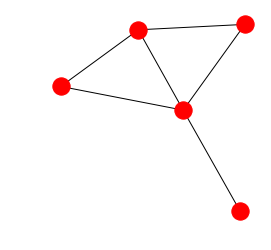

In [3]:
plt.figure(figsize=(3,3))
G = nx.from_numpy_matrix(A)
nx.draw(G)

### Random Networks

A Random Graph (or Erdös-Renyi Graph) is a graph constructed with a constant probability for an edge to exist between any two nodes. 
We can formalize this as: $ \forall i,j$, the probability $P(A_{ij}=1)=p$ for some probability $p \in [0,1]$. We can construct a random network with the following code:

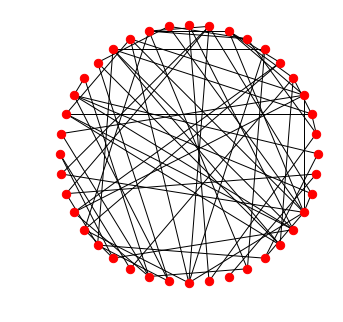

In [4]:
def erdos_renyi(n, p):
    # generate N x N random matrix
    A = np.random.choice([0, 1], size=(n, n), replace=True, p=[1-p, p])
    
    # use only lower triangle of A and fill upper part with transpose (-1 to avoid double diagonal)
    return np.tril(A) + np.tril(A, -1).T

# Creating a Random Network of 40 nodes with p=0.1
A = erdos_renyi(40, 0.1)
G = nx.from_numpy_array(A)

# Display network
plt.figure(figsize=(4,4)) 
nx.draw(G, nx.circular_layout(G), node_size=70)
plt.show()

Note that not all random graphs are connected. To check if graph is connected, we can visually inspect it or use the $\texttt{nx.is_connected}$ method:

In [5]:
connected = nx.is_connected(G)
print('Connected :', connected)

Connected : True


We can also see the degree (number of connections) distribution of this random graph with a histogram using:

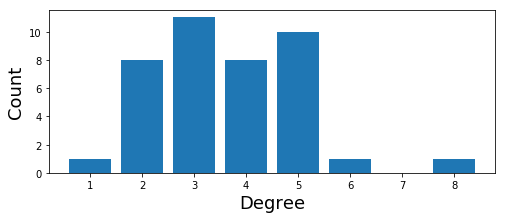

In [6]:
def hist_degree(G):
    # extract degrees of each node
    degrees = np.asarray([d for _, d in G.degree()])

    # calculate bin endpoints with centers corresponding to integer values
    bins = np.arange(np.min(degrees)-0.5, np.max(degrees)+1.5, 1)
    
    # calculate histogram of degrees
    hist, _ = np.histogram(degrees, bins=bins)
    
    # return histogram + corresponding degree values
    return hist, np.arange(np.min(degrees), np.max(degrees)+0.5, 1)


# plot histogram of degrees
hist, xs = hist_degree(G)
plt.figure(figsize=(8,3)) 
plt.bar(xs, hist)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Degree', fontsize=18)
plt.show()

### Watts-Strogatz Networks

Watts-Strogatz Network is a random graph generation model proposed by Duncan J. Watts and Steven Strogatz. It generates graphs with small-world properties, such as short average path lengths and high clustering. It is also known as (Watts) $\beta$ model based on the use of $\beta$ in the Six Degrees book.

Watts-Strogatz Networks can be created using 'networkx'. Alternatively, we can write a function to generate them by starting with a 2k-Regular network (also known as a Ring Lattice) and rewire the connections with a given probability ($\beta$).

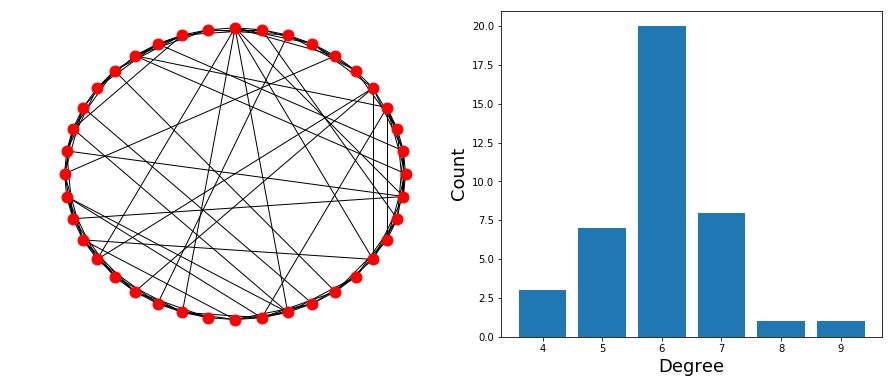

In [7]:
def ring_lattice(n, k):
    A = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(1,k+1):
            A[i,(i+j)%n], A[(i+j)%n,i] = 1, 1
            A[i,(i-j)%n], A[(i-j)%n,i] = 1, 1   
    return A

# QUESTION: Is it okay to rewire an edge that is already rewired?
def watts_strogatz(n, k, beta):
    A = ring_lattice(n, k)
    for i in range(n):
        for j in range(n):
            if A[i,j] and np.random.random() < beta:
                A[i,i] = 1 # to prevent self-edges
                new = np.random.choice(np.where(A[i,:] == 0)[0]) # select a random new edge
                A[i,new], A[new,i] = 1, 1 # connect new edges
                A[i,j], A[j,i], A[i,i] = 0, 0, 0 # remove old edges
    return A

# create and calculate histogram of degrees of a Watts-Strogatz Network
A = watts_strogatz(40, 3, 0.1)
G = nx.from_numpy_array(A)
hist, xs = hist_degree(G)

# plot network & histogram of degrees
plt.figure(figsize=(15,6))
plt.subplot(121)
nx.draw(G, nx.circular_layout(G), node_size=120)
plt.subplot(122)
plt.bar(xs, hist)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Degree', fontsize=18)
plt.show()

### Other Types of Networks


A *Regular graph* is a graph such that $\forall i, \text{Degree}(a_i) = k$ for some $k<N$. In other words, a Regular graph has an uniform degree distribution. 

Other commonly known networks are $N$-Dimensional grids and Barabasi-Albert Networks (random scale-free networks with preferential attachment).

Again, we can use networkx to constructor such graphs.

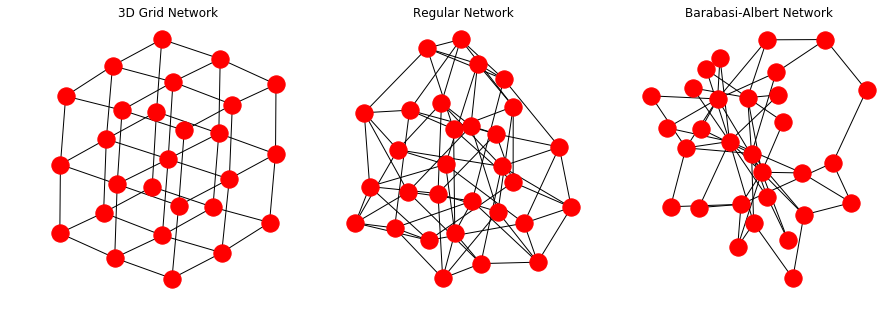

In [8]:
G_Grid3D = nx.grid_graph(dim=[3,3,3])
G_BA = nx.barabasi_albert_graph(30, 2)
G_Regular = nx.random_regular_graph(5, 30)

plt.figure(figsize=(15,5))
plt.subplot(131).title.set_text('3D Grid Network')
nx.draw(G_Grid3D)
plt.subplot(132).title.set_text('Regular Network')
nx.draw(G_Regular)
plt.subplot(133).title.set_text('Barabasi-Albert Network')
nx.draw(G_BA)

## Non-Linear Synchronization over Networks

Coupled Lorenz systems on a network can be defined using an adjacency matrix ($A$). In this case, the dynamics can be described as:<br>
\begin{aligned}
\mathbf{\dot{x}}_i = \mathbf{f}(\mathbf{x}_i) - \alpha \sum_{j=1}^N L_{ij} \mathbf{H}(x_j)
\end{aligned}
where $L$ is the Laplacian of the $A$ defined as $L_{ij}=k_{ij}\delta_{ij}-A_{ij}$ for $1 \le i,j \le N$ given that nodes are not connected to self ($A_{ij} = 0$ if $i=j$).

Let's start by describing and validating a network.


Connected : True


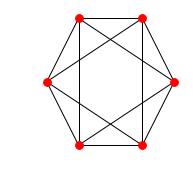

In [9]:
# create and visualize a ring lattice
n, k = 6, 2 # number of nodes, number of edges (in one-direction)
A = ring_lattice(n, k)
G = nx.from_numpy_array(A)

print('\nConnected :', nx.is_connected(G))
plt.figure(figsize=(2,2))
nx.draw(G, nx.circular_layout(G), node_size=60)
plt.show()

The critical coupling value is analytically found to be $\alpha_c=\frac{\Gamma(f,h)}{\lambda_2}$. If $H=I$, this can be written as $\frac{\Lambda}{\lambda_2}$ where $\Lambda$ is the Lyapunov exponent of the isolated dynamics.

In [10]:
def laplacian(A):
    D = np.sum(A, axis=1) # calculate the degree of each node
    D = np.diag(D) # construct a diagonal matrix of the degrees
    return D - A # compute the Laplacian matrix
L = laplacian(A)

eigval2 = np.sort(la.eigvals(L))[1] # sort eigenvalues and take the second lowest one
print('2nd Eigenvalue :', eigval2)

lyapunov = .93 # calculated on Day #2 for Lorenz(sigma=10, rho=28, beta=2.667)  
print('Alpha critical :', lyapunov / eigval2)

2nd Eigenvalue : 3.9999999999999982
Alpha critical : 0.23250000000000012


***

Now let's describe the dynamics of the network. 

First re-define our `integrate`, `rk4`, `lorenz` functions (see _Day #2_). Then,  create a function to simulate the coupled dynamics of the network given the subsystems as we did using the `couple_identical` function  on _Day #2_. 

In [11]:
def integrate(estimator, f, x, t=0, dt=0.01, n=100):
    """Numerical approximation of a trajectory in a vector field

    Parameters
    ----------
    estimator : function
        A function that estimates the change of value in trajectory from a given point.
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Initial value point of the trajectory.
    t         : float | tuple | array_like
        Initial time point | start and end time values | whole time points of the integration.
    dt        : float
        Time step will be used in the integration.
        Will only be used if `t` is not given as array_like.
    n         : int
        Number of steps will be used in the integration.
        Will only be used together with `dt` when `t` denotes the initial time value.

    Returns
    -------
    xs        : array_like
        a list of value points calculated with integration that start from given `x`.
    ts        : array
        a list of time points that corresponds to given value points.
    """

    # calculate time points that will be used in the integration
    if isinstance(t, float): # if given as (start) time point
        ts = np.arange(t, t + dt * n, dt) # start integrating from t using `dt` and `n`
    elif isinstance(t, tuple): # if given (start, end) time points
        ts = np.arange(t[0], t[1]+dt, dt) # utilize dt to find intermediate points 
    else: # if given as an array of time points
        ts = t

    xs = [ x ]
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # calculate time diff
        x = x + estimator(f, x, ts[i], dt) # calculate next point
        xs.append(x)
    return np.stack(xs), ts

def rk4(f, x, t, dt):
    """Estimates a change in trajectory using Runge-Kutta 4th order Method.

    Parameters
    ----------
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Value point of the estimation.
    t         : float | tuple | array
        Time point of the estimation. 
    dt        : float
        Time step will be used in estimation.

    Returns
    -------
    dx        : array_like
        Change estimated by RK4 Method.
    """
    
    k1 = f(x, t) * dt
    k2 = f(x + k1 * 0.5, t + dt * 0.5) * dt
    k3 = f(x + k2 * 0.5, t + dt * 0.5) * dt
    k4 = f(x + k3, t + dt * 0.5) * dt
    return (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0

def lorenz(sigma=10, rho=28, beta=2.667):
    """Defines a Lorenz dynamical system with given parameters.
    
    Returns
    -------
    _lorenz   : function
        Derivative function of the Lorenz system.
    """
    def _lorenz(x, t):
        return np.asarray([
            sigma * (x[1] - x[0]),
            x[0] * (rho - x[2]) - x[1],
            -beta * x[2] + x[0] * x[1]
        ])
    return _lorenz

In [12]:
def couple_identical_network(f, A, h=None, alpha=0.1):
    """Defines a coupled network consisting of identical subsytems.
    Assumes coupling is defined over the *difference* of states.

    Parameters
    ----------
    f         : function
        A vector field defining the isolated dynamics of subsystems.
    A         : array_like
        Adjacency matrix of the network.
    h         : function | array_like
        Coupling function or matrix defining the coupling dynamics between two subsystems.
    alpha     : float
        Coupling strength.

    Returns
    -------
    F         : function
        A vector field defining the dynamics of the whole network.
    """
    n = A.shape[0] # get the number of subsystems considered
    if h is None: # if h is not given, assume identity
        h = np.eye(n)

    def F(x, t):
        k = x.shape[1] # number of parameters in each subsystem, x's shape is (n x k)
        
        # calculate differences matrix
        x_row = np.repeat(x[:, np.newaxis, ...], n, axis=1) # (n x n x k)
        x_col = np.repeat(x[np.newaxis, ...], n, axis=0) # (n x n x k)
        x_diff = (x_col - x_row) # (n x n x k)
        
        # calculate coupling by applying h to each *difference state* of (k x 1)
        if callable(h): # if h is given as function (nonlinear)
            dx_coup = np.zeros((n, n, k))
            for i in range(n):
                for j in range(n):
                    if A[i, j]: # to save time only call h if nodes are connected
                        dx_coup[i, j, :] = alpha * h(x_diff[i, j, :])
        else: # if h is given explicitly as matrix (linear)
            dx_coup = alpha * np.tensordot(h, x_diff, axes=1) # (n x n x k)

        # prune coupling dynamics between unconnected nodes i.e i & j not connected -> (i,j,:) = 0
        # enlarge A by repeating on new axis (n x n) -> (n x n x k) and multiply point-wise
        dx_coup = dx_coup * np.repeat(A[..., np.newaxis], dx_coup.shape[-1], axis=-1)
            
        # calculate internal dynamics
        dx_diag = np.zeros((n, n, k)) # (n x n x k)
        for i in range(n):
            dx_diag[i, i, :] = f(x[i, :], t) # put internal dynamics to diagonal of tensor matrix
        
        # sum over columns to get derivatives for each subsystem
        return np.sum(dx_diag + dx_coup, axis=1) # (n x 1 x k ~ n x k)
    return F

Now, use this function to define a network system from simple single lorenz systems and plot their trajectories using our integrator & estimator. Assume coupling function is just identity over differences of states and the topology is from the previous example.

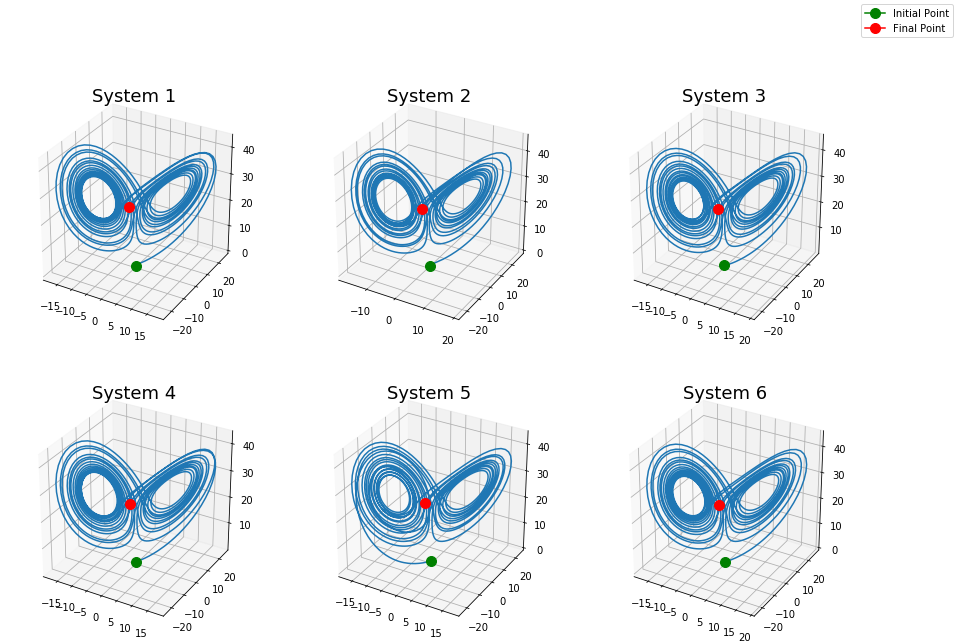

In [13]:
# define coupled lorenz network
params = {
    'sigma': 10,
    'rho': 28,
    'beta': 2.667  
}
alpha = 0.26
system = couple_identical_network(lorenz(**params), A=A, h=np.eye(n), alpha=alpha)

# define the initial conditions of Lorenzs slightly different from each other
x0 = np.random.uniform(-0.5, 0.5, [n, 3])
t = (0, 20)
dt = 0.01

# calculate trajectory with numerical integration
x_rk4, ts = integrate(rk4, f=system, x=x0, t=t, dt=dt)

# plot trajectories together in 3D
rows = 2
cols = n // rows
fig = plt.figure(figsize=(15, 10))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        ax = fig.add_subplot(rows, cols, index+1, projection='3d')
        ax.plot(xs=x_rk4[:, index, 0], ys=x_rk4[:, index, 1], zs=x_rk4[:, index, 2])
        pt1, = ax.plot(xs=x_rk4[:1, index, 0],
                       ys=x_rk4[:1, index, 1],
                       zs=x_rk4[:1, index, 2],
                       marker='o', markersize=10, color='g')
        pt2, = ax.plot(xs=x_rk4[-1:, index, 0],
                       ys=x_rk4[-1:, index, 1],
                       zs=x_rk4[-1:, index, 2],
                       marker='o', markersize=10, color='r')
        ax.set_title('System %d'  % (index+1), fontsize=18)
fig.legend([pt1, pt2], ['Initial Point', 'Final Point'])
plt.show();

***
The Synchronization Error of N Coupled Lorenz systems can be defined as :<br>
\begin{aligned}
E=\frac{2}{3N(N-1)} \sum_{d=1}^{3} \sum_{j<i, i=1}^N |x_{id}-x_{jd}|
\end{aligned}

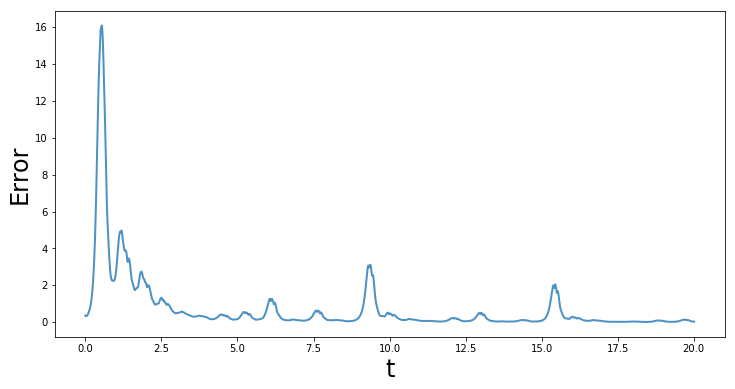

In [14]:
# define a function for synchronization error
def sync_error(x):
    n = x.shape[1] # assume x is in shape (t: time x n: number of systems x d: dimension of each system)
    x_row = np.repeat(x[..., np.newaxis, :], n, axis=2) # repeat systems in row (t x n x n x d)
    x_col = np.repeat(x[:, np.newaxis, ...], n, axis=1) # repeat systems in col (t x n x n x d)
    x_err = np.sum(np.abs(x_col - x_row), axis=3) # calculate error between pairs (t x n x n)
    x_err = np.sum(x_err, axis=(1,2)) # sum errors across all system pairs (t) 
    x_err = x_err / (3 * n * (n-1)) # skip 2 multiplier as we counted each pair twice (i,j) & (j,i)
    return x_err

# calculate error
err = sync_error(x_rk4)

# plot synchronization error
plt.figure(figsize=(12,6))
plt.plot(ts, err, linewidth=2, alpha=0.8)
plt.ylabel('Error', fontsize=24)
plt.xlabel('t', fontsize=24);